# 5 EMアルゴリズム

EMアルゴリズムを使用することで、混合ガウスモデル（GMM）のパラメータ推定を効率的に行うことができる。

今回のステップでは、EMアルゴリズムの導出と、実装を行う。

## 5.1 KLダイバージェンス

EMアルゴリズムの導出に重要な役割を果たす、KLダイバージェンスについて学ぶ。

また、数式の表記方法に二つの変更点を加える。まずは、変更点から話す。

### 5.1.1 数式の表記について

一つ目の変更点は、期待値の表記方法についてである。連続の確率変数$x$と、確率密度が$p(x)$で表されるとき、$f(x)$の期待値は次の式で表される。

$$\mathbb{E}_{p(x)}[f(x)] = \int f(x)p(x)dx$$

これまで、期待値は$\mathbb{E}[f(x)]$と表記したが、$p(x)$に関する期待値であることを明示する。例えば、確率分布$q(x)$に関する期待値であれば、

$$\mathbb{E}_{q(x)}[f(x)]=\int f(x)q(x)dx$$

と表される。

二つ目の変更点は、パラメータの表記場所である。パラメータ$\theta$の確率分布は、$p(x;\theta)$の形で表記していたが、今後は$p_\theta(x)$とする。どちらも同じ意味を持つ確率分布である。

### 5.1.2 KLダイバージェンスの定義式

ある二つの確率分布を測る尺度に **KLダイバージェンス(Kullback-Leibler divergence)** がある。

二つの確率分布$p_\theta(x),q_{\theta}(x)$がある時、KLダイバージェンスは

$$D_{KL}(p||q) = \int p(x)\log\frac{p(x)}{q(x)}dx$$

の式で表される。上式は連続型の確率変数の場合のKLダイバージェンスである。離散型の場合は、

$$D_{KL}(p||q) = \sum_xp(x)\log\frac{p(x)}{q(x)}$$

と表記される。KLダイバージェンスには次の特徴がある。

* 二つの確率分布が異なるほど大きな値を示す。
* ０以上の値を取り、二つの確率分布が同じ時のみ０になる
* 非対称な尺度であるため、$D_{KL}(p||q),D_{KL}(q||q)$異なる値になる。

KLダイバージェンスは、二つの確率分布がどれくらい異なるかを表す尺度として利用される

コインを例に実際にKLダイバージェンスを計算してみる。

あるAコインの表が出る確率が70%、裏が出る確率が３０％とする。ある人が、コインの表が出る確率が５０％、裏が出る確率が50%であると推定する。

コインAの確率分布を$p$推定した確率分布を$q$とするとKLダイバージェンスは次のように計算できる。

$$D_{KL}(p||q) = 0.7\log\frac{0.7}{0.5}+0.3\log\frac{0.3}{0.5} = 0.021$$

となる。次に、別の人が、表が出る確率が２０％、裏が出る確率が80%と推定したとする。KLダイバージェンスは

$$D_{KL}(p||q) = 0.7\log \frac{0.7}{0.2}+0.3\log\frac{0.3}{0.8} = 0.58$$

となる。はじめに推定した確率よりも大きくなっていることがわかる。最後に別の人が表が出る確率70%、裏が出る確率30%と推定したとするとKLダイバージェンスは

$$D_{KL}(p||q) = 0.7\log \frac{0.7}{0.7}+0.3\log\frac{0.3}{0.3} = 0$$

となり、一致することがわかる。他の値についても計算するため、簡単なプログラムを作って実行する

In [21]:
import numpy as np

def KLdiv(p,q):
    K = len(p)
    D = 0
    for k in range(K):
        D += p[k] * np.log(p[k] / q[k])
    
    return D

KLダイバージェンスを計算する関数KLdiv()を作成する。引数には、真の確率pと推定している確率qをとしている。

例題と同様に、コインの表と裏が出る確率を計算する。

In [25]:
p = [0.7,0.3]

Q = [[0.1*i , 1-0.1*i] for i in range(1,10)]

for q in Q:
    print("head ",q[0],"reverse ",q[1])
    print("                                                       KL-div ", KLdiv(p,q))

head  0.1 reverse  0.9
                                                       KL-div  1.0325534177382862
head  0.2 reverse  0.8
                                                       KL-div  0.5826853020432394
head  0.30000000000000004 reverse  0.7
                                                       KL-div  0.33891914415488134
head  0.4 reverse  0.6
                                                       KL-div  0.18378689738681217
head  0.5 reverse  0.5
                                                       KL-div  0.08228287850505178
head  0.6000000000000001 reverse  0.3999999999999999
                                                       KL-div  0.021600854143546483
head  0.7000000000000001 reverse  0.29999999999999993
                                                       KL-div  -1.1102230246251575e-17
head  0.8 reverse  0.19999999999999996
                                                       KL-div  0.028167557595283457
head  0.9 reverse  0.09999999999999998
                

KLダイバージェンスの値を見ると、表が出る確率が０.1、裏が出る確率が0.9の場合に最も大きくなっていることがわかる。また、事前に計算した通り、表70%裏30%ではKLダイバージェンスは非常に小さくなっていることがわかる。

一方で、表60%裏40％の場合0.021であり、表80%裏20%の場合0.028である。同じ10％ずつの差だがKLダイバージェンスの値は異なっている。

### 5.1.3 KLダイバージェンスと最尤推定の関係

KLダイバージェンスと最尤推定の関係について話す。

真の確率分布$p_*(x)$があり、サンプルデータ$\{x^{(1)},x^{(2)},\cdots,x^{(N)}\}$を生成したとする。目的は、パラメータ$\theta$で調整できる確率$p_{\theta}(x)$を使用して、$p_*(x)$にできるだけ近い確率分布を作る。

対数尤度を目的関数とする。

$$\log \prod^N_{n=1}p_\theta(x^{(n)})= \sum^N_{n=1}\log p_\theta(x^{(n)})$$

そして、この対数尤度を最大化するパラメータは次の式で表される。

$$\hat{\theta}=\arg\max_\theta\sum^N_{n=1}\log p_\theta (x^{(n)})$$

$\arg\max_\theta$は最大値を与える引数$\theta$を意味する。つまり、対数尤度を最大化する$\theta$を計算する。この式は、KLダイバージェンスを用いて導出することができる。それを証明する。

KLダイバージェンスは

$$D_{KL}(p_*||p_\theta) = \int p_*(x)\log\frac{p_*(x)}{p_\theta(x)}dx$$

の式で表される。この式を計算するためには、すべての$x$について積分をする必要がある。しかし、$p_*(x)$の具体的な数式が不明であるため、計算ができない。そこで、**モンテカルロ法** を用いて近似する。

モンテカルロ法を用いて、期待値を求める手法を説明する。

$$\mathbb{E}_{p_*(x)}[f(x)]=\int p_*(x)f(x)dx$$

は連続な確率変数$x$を持つ確率密度$p_*(x)$と、任意の関数$f(x)$である。モンテカルロ法を用いると上式は次のように近似できる。

1. 確率分布$p_*(x)$に基づいてサンプル$\{x^{(1)},x^{(2)},\cdots,x^{(N)}\}$を生成する。
2. 各データ$x^{(i)}$における$f(x^{(i)})$を求め、その平均を計算する。

この手順により、積分を近似して表すことができる。

$$\mathbb{E}_{p_*(x)} = \int p_*(x)f(x)dx \approx \frac{1}{N}\sum^N_{n=1}f(x^{(n)})\\ (x^{(n)}\sim p_*(x))$$

記号$\approx$は近似的に等しいことを意味し、$x^{(n)}\sim p_*(x)$は$x^{(n)}$が確率分布$p_*(x)$に従うことを意味する。モンテカルロ法によって、関数$f(x)$の期待値を計算することができる。実際にモンテカルロ法を用いて期待値を求めてみる。

確率$p(x)$を一様関数とし、定積分と同じ結果を得ることができる。関数$x^2$を区間$[0:1]$で定積分すると$\frac{1}{3}$となる。

In [35]:
import numpy as np

K=10000

x = np.random.uniform(0, 1, K)

exp_x = sum(x*x) / K

print(exp_x)

0.32994007835910655


実際に計算すると、$\frac{1}{3}$に近くなっていることがわかる。

モンテカルロ法は、ランダムに生成されたサンプルを用いて、問題をシミュレートし、それらのサンプルから求めた結果の平均を取ることで、計算結果の解を近似できることが実感できる。

期待値における関数$f(x)$を$\log\frac{p_*(x)}{q_\theta(x)}$としてモンテカルロ法を適用する。

$$D_{KL}(p_*(x) || p_\theta) = \int p_*(x)\log\frac{p_*(x)}{p_\theta(x)}dx \\
\approx \frac{1}{N}\sum^N_{n=1}\log\frac{p_*(x^{(n)}}{p_\theta(x^{(n)}}(x^{(n)}\sim p_*(x))\\
=\frac{1}{N} \sum^N_{n=1} \left( \log p_*(x^{(n)})-\log p_\theta (x^{(n)})\right)
$$

その結果、KLダイバージェンスは上のように変形される。目的は、$D_{KL}(p_* || p_\theta)$を最小にする$\theta$を求めることである。従って、$\theta$を含まない項を無視して

$$\arg\min_\theta D_{KL} \approx \arg\min_\theta\left(-\frac{1}{N}\sum^N_{n=1}\log p_\theta(x_n)\right) \\
 = \arg\min_\theta \left( - \sum ^N_{n=1}\log p_\theta(x_n)\right)\\
 = \arg\max_\theta \sum^N_{n=1}\log p_\theta(x_n)$$
 
途中で、目的関数を$N$倍しているが、最小値をとる$\theta$は変わらない。目的関数の符号を反転させると、最小の$\min$から、最大の$\max$に変わる。以上より

$$\arg\min_\theta D_{KL}(p_*||p_\theta)\approx \arg\max_\theta\sum^N_{n=1}\log p_\theta(x_n)$$

となる。左辺は、KLダイバージェンスが最小となる$\theta$、右辺は対数尤度が最大となる$\theta$を意味している。

## 5.2 EMアルゴリズムの導出①

GMMは潜在変数を持つ確率分布のモデルである。潜在変数を持つモデルは他にもVAEやHMMがある。HMM隠れマルコフモデルの略である。

EMアルゴリズムは、GMMだけではなく、潜在変数を持つモデルに対して適用することができる。はじめに、潜在変数を持つモデルに適応しその後にGMMに適応する。

EMアルゴリズムはExpectation-Maximizationの略で、ExpectationステップとMaximizationステップを繰り返し、パラメータを更新する。

### 5.2.1 潜在変数を持つモデル

観測できる確率変数を$x$潜在変数を$z$、パラメータ$\theta$で表す。対数尤度は、確率の周辺化により、次の式で表される。

$$\log p_\theta(x)=\log\sum_zp_\theta(x,z)$$

真の確率分布$p_*$からサンプル$\mathcal{D}=\{x^{(1)},x^{(2)},\cdots,x^{(n)}\}$が得られたとする。この時の対数尤度は

$$\log p_\theta(\mathcal{D}) = \log\left(p_\theta(x^{(1)}p_\theta(x^{(2)})\cdots p_\theta(x^{(n)}\right)\\
 = \sum^N_{n=1}\log p_\theta(x^{(n)}) \\
 = \sum^N_{n=1}\log\sum_{z(n)}p_\theta(x^{(n)},z^{(z)})$$
この対数尤度を最大化したいが、log-sumの形だったが、EMアルゴリズムはこの問題をsum-logの形に変換し解く。

まずは、乗法定理を使用し式を変形させる。

$$\log p_\theta(x) = \log\frac{p_\theta(x,z)}{p_\theta(z|x)}$$

一見、対数を加減にすることで解決しているように見えるが、条件付き確率$p_\theta(z|x)$が難点である。なぜなら、ベイズ定理より

$$p_\theta(z|x)=\frac{p_\theta(x,z)}{\sum_zp_\theta(x,z)}$$

と表される。分母に$\sum$があり、log-sumの形から逃れることができない。



ここでは、離散型を想定しているが、連続型では、$\sum$を$\int$にかえることで同様の結果が得られる。

### 5.2.2 任意の確率分布$q(z)$

厄介者である$p(z|x)$に対処するため、任意の確率分布$q(z)$を使用する。$q(z)$は、$p_\theta(z|x)$の近似分布として用いる。

対数尤度を$q(z)$を使用して

$$\log p_\theta(x) = \log\frac{p_\theta(x,z)}{p(z|x)} = \log\frac{p_\theta(x,z)}{p(z|x)}\frac{q(z)}{q(z)}=\log\frac{p_\theta(x,z)}{q(z)}+\log\frac{q(z)}{p(z|x)}$$

と表すことができる。この確率密度$q(z)$が潜在変数に対応しているように見える。

第一項は$p(z|x)$から$q(z)$へ変更することができた。一方で、第二項には$p(z|x)$が存在する。よって第二項をKLダイバージェンスの形式に変形する。

$$\log p_\theta(x) = \log p_\theta(x) \sum_zq(z) \\
 = \sum q(z)\left(\log\frac{p_\theta(x,z)}{q(z)}+\log\frac{q(z)}{p(z|x)}\right)\\
 = \sum q(z) \log\frac{p_\theta(x,z)}{q(z)}+\sum_z \log\frac{q(z)}{p(z|x)}\\
 = \sum q(z) \log\frac{p_\theta(x,z)}{q(z)}+D_{KL}(q(z)||p_\theta(z|x))$$

第二項をKLダイバージェンスとして表すことができた。これが、EMアルゴリズムを導くための式となる。

## 5.3 EMアルゴリズムの導出②

①で得られた対数尤度は

$$ \log p_\theta(x)=\sum_z q(z)\log \frac{p_\theta(x,z)}{q(z)}+D_{KL}(q(z)||p_\theta(z|x)$$

である。この式似ついて考察を続ける。

### 5.3.1 ELBO(エビデンスの下界)

KLダイバージェンスの計算結果は、常に０以上になる。そのため、

$$ \log p_\theta(x)=\sum_z q(z)\log \frac{p_\theta(x,z)}{q(z)}+D_{KL}(q(z)||p_\theta(z|x) \geq \sum_z q(z)\log \frac{p_\theta(x,z)}{q(z)}$$

が成立する。第一項の$\sum_z \log \frac{p_\theta(x,z)}{q(z)}$は、対数尤度以下の値であり、ELBO(Evidence Lower BOund)と呼ばれエビデンスの下界と訳される。

この場合のエビデンスは、対数尤度が大きくなることで$q$,$\theta$が正しい方向を示している根拠であることを示す。この第一式は、ELBOと呼ばれ

$$\rm{ELBO}(x;q,\theta)=\sum_zq(z)\log\frac{p_\theta(x,z)}{q(z)}$$

の表記を用いる。$\rm{ELBO}(x;q,\theta)$には重要な特徴があり

* 対数尤度$\log p_\theta(x)$は常に$\rm{ELBO}(x;q,\theta)$以上の値になる
* $\rm{ELBO}(x;q,\theta)$はsum-logの形になっており、解析しやすい

ELBOを大きくするようにパラメータを更新する。$\log p_\theta(x)$の代わりとして、ELBOを最適化の対象にすることを考える。

つまり、対数尤度の第一項に注目し最適化する。

### 5.3.2 EMアルゴリズムへ

$\rm{ELGO}(x;q,\theta)$には$q(z),\theta$の二つのパラメータがある。この二つのパラメータを最適化しELGOを最大化する。

二つのパラメータを同時に最適化することは難しいため、一方を固定しもう片方のパラメータを最適化する。この作業を繰り返す。

まずは、$\theta=\theta_{\rm{old}}$として$\theta$を固定し$q(z)$を最適化する。

$q(z)$の分布によって、$\rm{ELBO}(x;q,\theta)$が$\log p_\theta(x)$にどれくらい近づくかが変化する。これは、KLダイバージェンスがゼロに近づくことで、対数尤度と$\rm{ELBO}$が等しくなる。

式

$$\log p_\theta(x) = \rm{ELBO}(x;q,\theta)+D_{\rm{KL}}(q(z)||p_\theta(z|x))$$

に注目すると、対数尤度では任意の確率分布$q(z)$に依らずELBO項とKL項の和が一定であることがわかる。

KL項を小さくすることで、ELBO項は大きくなる。KLダイバージェンスは$q(z)$と$p_\theta(z|x)$が等しい場合に０となる。その時の対数尤度$\log p_\theta(x)$は$\rm{ELBO}(x;q,\theta)$と等しくなる。

よって、$q(z)$の更新式は$q(z)=p_{\theta_{\rm{old}}}(z|x)$と表すことができる。つまり、KLダイバージェンスが小さくなるように、確率分布を変化させる。

$q(z)=p_{\theta_{\rm{old}}}(z|x)$による更新は、Eステップと呼ばれる。これはExpectation ValueのEからきている。これは、$q(z)=p_{\theta_{\rm{old}}}(z|x)$の時ELBOが

$$\rm{ELBO}(x;q=p_{\theta_{\rm{old}}}(z|x),\theta) = \sum_zp_{\theta_{\rm{old}}}(z|x)\log\frac{p_\theta(x,z)}{p_{\theta_{\rm{old}}}(z|x)} = \mathbb{E}_{{\theta_{\rm{old}}}(z|x)}\left[ \log\frac{p_\theta(x,z)}{p_{\theta_{\rm{old}}}(z|x)} \right]$$

期待値として表されることに起因する。

次に$\theta$の最適化を行う。これは、解析的に求めることができる。Mステップと呼ばれ、Maximizationの頭文字から来ている。

Mステップを行うことで、ELBOの値は増加するが一方でEステップで一致した対数尤度とELBOは遠ざかる。

EステップとMステップを交互に繰り返すことで、対数尤度が変化しなくなる。EMアルゴリズムによる更新のやめ時である。


### 中まとめ

対数尤度は潜在変数$z$を生成する任意の確率分布$q(z)$を使用して

$$\log p_\theta(x) = \sum q(z) \log\frac{p_\theta(x,z)}{q(z)}+D_{KL}(q(z)||p_\theta(z|x))$$

と表される。対数尤度の下限Expectation Lower BOundaryは第一項である。これは、KLダイバージェンスが０以上になるためである。

$$\rm{ELBO}(x;q,\theta)=\sum_zq(z)\log\frac{p_\theta(x,z)}{q(z)}$$

対数尤度を最大化するために、ELBOを最大化する。ELBOは$q(z),\theta$の二つの変数を持つ関数であるため、$q(z), \theta$をそれぞれ更新させる。

$q(z)$を更新するステップをEステップ、$\theta$を更新するステップをMステップと呼ぶ。呼称は、それぞれの更新に使用する式から期待値のExpectation,最大値のMaximizationの頭文字をとっている。

Eステップでは、$\theta={\theta_{\rm{old}}}$と固定し、$q(z)=p_{\theta_\rm{old}}(z|x)$の更新式を用いて更新する。つまり、$q(z)$を$p_{\theta_\rm{old}}(z|x)$に近づける。
更新し、ELBOを対数尤度に近づける。

Mステップでは、ELBOが最大になる$\theta$を計算する。
Eステップで計算したELBOと対数尤度は遠ざかる。

このEステップとMステップを交互に繰り返すことで対数尤度を徐々に大きくする。


### 5.3.3 複数データへの拡張

観測データがN個ある場合に対して、EMアルゴリズムを適用する。

観測データ${x^{(1)},x^{(2)},\cdots,x^{(N)}}$に対して、任意の確率分布${q^{(1)},q^{(2)},\cdots,q^{(N)}}$をN個用意する。

対数尤度とELBOの関係は次のように表される。

$$\sum^N_{n=1}\log\sum_{x^{(n)}}p_\theta(x^{(n)},z^{(n)})\leq\sum^N_{n=1}\rm{ELBO}(x^{(n)};q^{(n)},\theta)\\
 =\sum^N_{n=1}\sum_{z^{(n)}}q^{(n)}(z^{(n)})\log\frac{p_\theta(x^{(n)},z^{(n)})}{q^{(n)}(z^{(n)})}$$
 
サンプリングしていたデータが一つの場合との違いは、$\sum^N_{n=1}$の有無である。

一つのデータの場合と同様に、任意の確率分布$q^{(n)}(z)$が$p_\theta(z|x^{(n)}$の場合に対数尤度は最大となる。

EMアルゴリズムの更新を止める尤度の判定として、対数尤度の平均を用いることができる。

$$\frac{1}{N}\sum^N_{n=1}\log p(x^{(n)};\theta)$$

以上から、EMアルゴリズムは次のようにまとめられる。

1. **Eステップ** : $\{q^{(1)},q^{(2)},\cdots,q^{(N)}\}$の更新($\theta$は固定)

     各$n$に対して$q^{(n)}(z) = p_\theta(z|x^{(n)})$とする。

2. **Mステップ** : $\theta$の更新($\{q^{(1)},q^{(2)},\cdots,q^{(N)}\}$は固定する)

    $\sum^N_{n=1}\rm{ELBO}(x^{(n)};q^{(n)},\theta)$が最大になる$\theta$を解析的に求める
3. **終了判定** : 対数尤度の平均を計算し、前回の対数尤度と比較する。

### 5.3.4 $\log p(x;\theta_{new})\geq\log p(x;\theta_{old})$の証明

Eステップにおいて、$q_{\rm{old}}=p_{\theta_{\rm{old}}(z|x)}$で更新した時、対数尤度とELBOは一致する。

$$\log p(x;\theta_{\rm{old}}) = \rm{ELBO}(x;q_{\rm{old}},\theta_{\rm{old}})$$

Mステップでは、ELBOを最大化することで、$\theta_{\rm{new}}$を得る。

$$\rm{ELBO}(x;q_{\rm{old}},\theta_{\rm{new}}) \geq \rm{ELBO}(x;q_{\rm{old}},\theta_{\rm{old}})$$

さらにその次のEステップでは、$q_{\rm{new}}=p_{\theta_{\rm{new}}(z|x)}$で更新する。

$$\log p(x;\theta_{\rm{new}}) = \rm{ELBO}(x;q_{\rm{new}},\theta_{\rm{new}})\\
 \geq \rm{ELBO}(x;q_{\rm{old}},\theta_{\rm{new}})$$
 
これで、$\theta$,$q$を更新できた。これをまとめると

$$\log p(x;\theta_{\rm{new}}) \geq \rm{ELBO}(x;q_{\rm{old}},\theta_{\rm{new}})\\
\geq \rm{ELBO}(x;q_{\rm{old}},\theta_{\rm{old}})\\
 = \log p (x;\theta_{\rm{old}})$$

なとり、$\log p(x;\theta_{\rm{new}}) \geq\log p (x;\theta_{\rm{old}})$が証明できる。

## 5.4 GMMとEMアルゴリズム

潜在変数を持つモデルから、EMアルゴリズムの導出を行った。次に、実際にGMMに対してEMアルゴリズムを導入する。

### 5.4.1 EMアルゴリズムのEステップ

GMMの復習をする。

GMMのパラメータ$\theta = \{\phi,\mu, \sigma\}$で表す。$\phi$はカテゴリカル分布、$\mu$は平均ベクトル、$\Sigma$は共分散行列　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　を意味する。

$$\Phi=\{\phi_1,\phi_2,\cdots,\phi_K\}\\
\mu = \{\mu_1,\mu_2,\cdots,\mu_K\}\\
\Sigma = \{\Sigma_1,\Sigma_2,\cdots,\Sigma_K\}$$

この時、尤度は

$$p(x,\theta) = \sum^k_{j=1}p(x,z=j;\theta)\\
 = \sum^K_{j=1}p(z=j;\boldsymbol{\theta})p(\boldsymbol{x}|z=j;\boldsymbol{\theta})\\
 = \sum^k_{j-1}\phi_j\mathcal{N}(\boldsymbol{x};\boldsymbol{\mu}_j,\boldsymbol{\Sigma}_j)$$

と表される。ここで、$N$個の観測データ$\{\boldsymbol{x}^{(1)},\boldsymbol{x}^{(2)},\cdots,\boldsymbol{x}^{(N)}\}$が得られた場合、データの対数尤度の平均は次の式で表される。

$$\frac{1}{N}\sum^N_{n=1}\log p(\boldsymbol{x}^{(n)};\boldsymbol{\theta})= \frac{1}{N}\sum^{N}_{n=1}\log\sum^K_{j=1}\phi_j\mathcal{N}(\boldsymbol{x}^{(n)};\boldsymbol{\mu}_j,\boldsymbol{\Sigma}_j)
$$

Eステップでは、$\{\phi,\mu,\Sigma\}$を固定し、確率分布$q^{(n)}(z)$を更新する。$q^{(n)}(z)$は$x^{(n)}$が与えられた時の条件付き確率として表される。

$$q^{(n)}(z=k)=p(z=k|\boldsymbol{x}^{(n)};\boldsymbol{\theta})\\
=\frac{p(\boldsymbol{x}^{(n)},z=k;\boldsymbol{\theta}}{p(\boldsymbol{x}^{(n)};\boldsymbol{\theta})}\\
=\frac{\phi_k\mathcal{N}(\boldsymbol{x}^{(n)};\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k)}{\sum^K_{j=1}\phi_j\mathcal{N}(\boldsymbol{x}^{(n)};\boldsymbol{\mu}_j,\boldsymbol{\Sigma}_j)}
$$

以降では、$q^{(n)}(z=k)$を$q^{(n)}(k)$と表す。まとめると

#### Eステップ
各$n,k$に対して次の値を計算する。
    $$q^{(n)}(k)= \frac{\phi_k\mathcal{N}(\boldsymbol{x}^{(n)};\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k)}{\sum^K_{j=1}\phi_j\mathcal{N}(\boldsymbol{x}^{(n)};\boldsymbol{\mu}_j,\boldsymbol{\Sigma}_j)}
$$

#### Mステップ
次で行う

#### 終了判定
次の対数尤度を計算し、前回の対数尤度と比較する。
$$\frac{1}{N}\sum^{N}_{n=1}\log\sum^K_{j=1}\phi_j\mathcal{N}(\boldsymbol{x}^{(n)};\boldsymbol{\mu}_j,\boldsymbol{\Sigma}_j)
$$

### 5.4.2EMアルゴリズムのMステップ

Mステップでは、$\boldsymbol{\theta}=\{\phi,\boldsymbol{\mu},\boldsymbol{\Sigma}\}$を更新する。ELBOを最大化するパラメータを求める。前節で話した、解析的に解けるという点について述べる

$$\sum^N_{n=1}\rm{ELBO}(\boldsymbol{x}^{(n)};q^{(n)},\boldsymbol{\theta})\\
=\sum^N_{n=1}\sum^K_{j=1}q^{(n)}(j)\log\frac{p(\boldsymbol{x}^{(n)},z^{(n)}=j;\theta)}{q^{(n)}(j)}\\
=\sum^N_{n=1}\sum^K_{j=1}q^{(n)}(j)\log\frac{\phi_j\mathcal{N}(\boldsymbol{x}^{(n)},\boldsymbol{\mu}_j,\boldsymbol{\Sigma}_j)}{q^{(n)}(j)}\\
=\sum^N_{n=1}\sum^K_{j=1}q^{(n)}(j)\log\phi_j\mathcal{N}(\boldsymbol{x}^{(n)},\boldsymbol{\mu}_j,\boldsymbol{\Sigma}_j) - \sum^N_{n=1}\sum^K_{j=1}q^{(n)}(j)\log q^{(n)}(j)$$

ここで、第二項の$\sum^N_{n=1}\sum^K_{j=1}q^{(n)}(j)\log q^{(n)}(j)$は$\{\phi,\boldsymbol{\mu},\boldsymbol{\Sigma}\}$と無関係であり、パラメータ$\theta$の最適化には無視することができる。目的関数を$J(\phi,\boldsymbol{\mu},\boldsymbol{\Sigma})$で表記すると

$$J(\phi,\boldsymbol{\mu},\boldsymbol{\Sigma}) = \sum^N_{n=1}\sum^K_{j=1}q^{(n)}(j)\log\phi_j\mathcal{N}(\boldsymbol{x}^{(n)},\boldsymbol{\mu}_j,\boldsymbol{\Sigma}_j)\\
 = \sum^N_{n=1}\sum^K_{j=1}q^{(n)}(j)\left(\log\phi_j\mathcal{N}(\boldsymbol{x}^{(n)},\boldsymbol{\mu}_j,\boldsymbol{\Sigma}_j)\right)$$
 
と表すことができる。初めに、$\boldsymbol{\mu}$を最適化する。$k$番目の$\mu$に関して勾配を求める。

$$\frac{\partial J}{\partial \boldsymbol{\mu}_k} = \frac{\partial}{\partial \boldsymbol{\mu}_k}\sum^N_{n=1}\sum^K_{j=1}q^{(n)}(j)\left(\log\phi_j\mathcal{N}(\boldsymbol{x}^{(n)},\boldsymbol{\mu}_j,\boldsymbol{\Sigma}_j)\right)\\
=\frac{\partial}{\partial \boldsymbol{\mu}_k}\sum^N_{n=1}\sum^K_{j=1}q^{(n)}(j)\log\mathcal{N}(\boldsymbol{x}^{(n)};\boldsymbol{\mu}_j,\Sigma_j)\\
= \sum^N_{n=1}q^{(n)}(k)\frac{\partial}{\partial \boldsymbol{\mu}_k}\log\mathcal{N}(\boldsymbol{x}^{(n)};\boldsymbol{\mu}_j,\Sigma_j)
$$

$j=k$以外の場合に関する微分は０になる。具体的には、

$j=1$から$K$に対して$\frac{\partial}{\partial \boldsymbol{\mu}_k}\log \phi_j=0$

$j\neq k$の$j=1$から$K$に対して$\frac{\partial}{\partial \boldsymbol{\mu}_k}\log\mathcal{N}(\boldsymbol{x}^{(n)};\boldsymbol{\mu}_j,\Sigma_j)=0$

これは、多次元正規分布の最尤推定の導出で導出した
$$\frac{\partial}{\partial \boldsymbol{\mu}}\log\mathcal{N}(\boldsymbol{x}^{(n)};\boldsymbol{\mu}_j,\Sigma_j) = \Sigma^{-1}(\boldsymbol{x} -\boldsymbol{\mu})$$

を利用することができる。これにより、

$$\frac{\partial J}{\partial \boldsymbol{\mu}_k}\sum^N_{n=1}q^{(n)}(k)\Sigma^{-1}(\boldsymbol{x}^{(n)}-\boldsymbol{\mu}_k)$$

が得られる。

$$
\sum^N_{n=1}(k)\Sigma^{-1}_k(\boldsymbol{x}^{(n)}-\boldsymbol{\mu}_k=0\\
\Sigma_k\sum^N_{n=1}(k)\Sigma^{-1}_k(\boldsymbol{x}^{(n)}-\boldsymbol{\mu}_k)=\Sigma_k\cdot0\\
\sum^N_{n=1}(k)\Sigma_k\Sigma^{-1}_k(\boldsymbol{x}^{(n)}-\boldsymbol{\mu}_k)=0\\
\sum^N_{n=1}q^{(n)}(k)(\boldsymbol{x}^{(n)}-\boldsymbol{\mu}_k=0\\
\sum^N_{n=1}q^{(n)}(k)\boldsymbol{\mu}_k = \sum^N_{n=1}q^{(n)}(k)\boldsymbol{x}^n\\
\boldsymbol{\mu}_k\left(\sum^N_{n=1}q^{(n)}(k)\right) = \sum^N_{n=1}q^{(n)}(k)x^{(n)}
$$

よって

$$\boldsymbol{\mu}_k=\frac{\sum^N_{n=1}q^{(n)}(k)x^{(n)}}{\sum^N_{n=1}q^{(n)}(k)}$$

これが、$\mu_k$の更新式である。これを、$k=1$から$K$まで続ける。

次に、$\Sigma$について、$\mu$と同様に、以前に求めた式を使用する。

$$\Sigma_k = \frac{\sum^N_{n=1}q^{(n)}(k)(\boldsymbol{x}^{(n)}-\boldsymbol{\mu}_k)(\boldsymbol{x}^{(n)}-\boldsymbol{\mu}_k)^\top}{\sum^N_{n=1}q^{(n)}(k)}$$

ここで、$\mu_k$は更新ずみの値である。

最後に、カテゴリカル分布$\phi$について更新をする。$\phi$に関する項は

$$\sum^N_{n=1}\sum^K_{j=1}q^{(n)}(j)\log \phi_j$$

である。$\phi$の最適化は$\mu$と異なり、次の制約がある。

$$\sum^K_{j=1}\phi_j=1$$

ラグランジュの未定乗数法を使用することで、解くことができる。

ラグランジュ未定乗数法では、$g(x)=0$のもとで$f(x)$を最大化する。そのためには、

$$L = f(x) -\beta g(x)$$

を定義する。$L,\beta$はそれぞれ、ラグランジアン、ラグランジュ乗数

$$\frac{\partial L}{\partial x} = 0\\
\frac{\partial L}{\partial \beta} = 0$$

この二つの連立方程式を解くことで、$x$の極値がわかる。

今回の問題を適用するとラグランジアンは次のように表される。

$$L=\sum^N_{n=1}\sum^K_{j=1}q^{(n)}(j)\log\phi_j +\beta\left(\sum^K_{j=1}\phi_j-1\right)$$

この時$L$の$\phi_k$に関する微分は

$$\frac{\partial L}{\partial \phi_k} = \sum^N_{n=1}q^{(n)}(k)\frac{\partial L}{\partial \phi_k}\log\phi_j +\beta\\
 = \sum^N_{n=1}q^{(n)}(k)\frac{q^{(n)}(k)}{\phi_k}+\beta$$

解は、次になる。

$$\phi_k = \frac{\sum^N_{n=1}q^{(n)}(k)}{-\beta}$$

この解をカテゴリカル分布の制約条件に当てはめると

$$ \sum^K_{j=1}\frac{\sum^N_{n=1}q^{(n)}(j)}{-\beta}=1\\
-\beta = \sum^K_{j=1}\sum^N_{n=1}q^{(n)}(j)\\
-\beta = \sum^K_{j=1}\sum^N_{n=1}q^{(n)}(j)\\
-\beta = N$$
となる。ここで、$q^{(n)}(z)$は、$z$の確率分布であり、zに関する和は１となる。(各zを取り得る値の和$q(j)$は$q(z=j)$を意味する。）そのため、上式が成立する。

$-\beta = N$を代入することで、次の式を得る。

$$\phi_k=\frac{1}{N}\sum^N_{n=1}q^{(n)}(k)$$

以上で、GMMに対するEMアルゴリズムの導出は完了です。

#### Eステップ
各$n,k$に対して次の値を計算する。
    $$q^{(n)}(k)= \frac{\phi_k\mathcal{N}(\boldsymbol{x}^{(n)};\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k)}{\sum^K_{j=1}\phi_j\mathcal{N}(\boldsymbol{x}^{(n)};\boldsymbol{\mu}_j,\boldsymbol{\Sigma}_j)}
$$

#### Mステップ
各$k$に対して次の値を計算する。
$$\phi_k=\frac{1}{N}\sum^N_{n=1}q^{(n)}(k)$$

$$\boldsymbol{\mu}_k=\frac{\sum^N_{n=1}q^{(n)}(k)x^{(n)}}{\sum^N_{n=1}q^{(n)}(k)}$$

$$\Sigma_k = \frac{\sum^N_{n=1}q^{(n)}(k)(\boldsymbol{x}^{(n)}-\boldsymbol{\mu}_k)(\boldsymbol{x}^{(n)}-\boldsymbol{\mu}_k)^\top}{\sum^N_{n=1}q^{(n)}(k)}$$

#### 終了判定
次の対数尤度を計算し、前回の対数尤度と比較する。
$$\frac{1}{N}\sum^{N}_{n=1}\log\sum^K_{j=1}\phi_j\mathcal{N}(\boldsymbol{x}^{(n)};\boldsymbol{\mu}_j,\boldsymbol{\Sigma}_j)
$$

## 5.5 EMアルゴリズムの実装

オールドフェイスフルカイザーのデータセットを使用してEMアルゴリズムの実装を行う。

最終的に、パラメータが未知のGMMに対してパラメーターを探索する。

### 5.5.1 データセットとGMMのコード

学習に使うデータを読み込み、GMMのパラメータの初期値を設定する。

In [4]:
import numpy as np
import matplotlib.pyplot as plt

path = 'old_faithful.txt'
xs = np.loadtxt(path)
print(xs.shape) # (272, 2)

# initialize parameters
phis = np.array([0.5, 0.5])
mus = np.array([[0.0, 50.0], [0.0, 100.0]])
covs = np.array([np.eye(2), np.eye(2)])

K = len(phis)  # 2
N = len(xs)  # 272
MAX_ITERS = 100
THRESHOLD = 1e-4


(272, 2)


xsの中身をみてみると

In [5]:
xs[0]

array([ 3.6, 79. ])

二次元のデータが２７２個あることを意味する。MAX_ITERはEMアルゴリズムの最大繰り返し回数を示す。THRESHOLDは対数尤度の差分の絶対値で閾値を設定している。

In [6]:
def multivariate_normal(x, mu, cov):
    det = np.linalg.det(cov)
    inv = np.linalg.inv(cov)
    d = len(x)
    z = 1 / np.sqrt((2 * np.pi) ** d * det)
    y = z * np.exp((x - mu).T @ inv @ (x - mu) / -2.0)
    return y

def gmm(x, phis, mus, covs):
    K = len(phis)
    y = 0
    for k in range(K):
        phi, mu, cov = phis[k], mus[k], covs[k]
        y += phi * multivariate_normal(x, mu, cov)
    return y

def likelihood(xs, phis, mus, covs):
    """ log likelihood """
    eps = 1e-8
    L = 0
    N = len(xs)
    for x in xs:
        y = gmm(x, phis, mus, covs)
        L += np.log(y + eps)
    return L / N

はじめの二つの関数は、４章で実装したコードと同じである。最後のlikelihoodhは対数尤度を求める関数である。

$$\frac{1}{N}\sum^{N}_{n=1}\log\sum^K_{j=1}\phi_j\mathcal{N}(\boldsymbol{x}^{(n)};\boldsymbol{\mu}_j,\boldsymbol{\Sigma}_j)
$$

np.log(0)を防ぐために、微小値epsを与えている。

### 5.2.2 EステップとMステップの実装

#### Eステップ
各$n,k$に対して次の値を計算する。
    $$q^{(n)}(k)= \frac{\phi_k\mathcal{N}(\boldsymbol{x}^{(n)};\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k)}{\sum^K_{j=1}\phi_j\mathcal{N}(\boldsymbol{x}^{(n)};\boldsymbol{\mu}_j,\boldsymbol{\Sigma}_j)}
$$

これをコードに書くと

In [7]:
for iter in range(MAX_ITERS):
    # E-step ====================
    qs = np.zeros((N, K))
    for n in range(N):
        x = xs[n]
        for k in range(K):
            phi, mu, cov = phis[k], mus[k], covs[k]
            qs[n, k] = phi * multivariate_normal(x, mu, cov)
        qs[n] /= gmm(x, phis, mus, covs)

となる。Mステップは

#### Mステップ
各$k$に対して次の値を計算する。
$$\phi_k=\frac{1}{N}\sum^N_{n=1}q^{(n)}(k)$$

$$\boldsymbol{\mu}_k=\frac{\sum^N_{n=1}q^{(n)}(k)x^{(n)}}{\sum^N_{n=1}q^{(n)}(k)}$$

$$\Sigma_k = \frac{\sum^N_{n=1}q^{(n)}(k)(\boldsymbol{x}^{(n)}-\boldsymbol{\mu}_k)(\boldsymbol{x}^{(n)}-\boldsymbol{\mu}_k)^\top}{\sum^N_{n=1}q^{(n)}(k)}$$

と表される。コードでは

In [8]:
for iter in range(MAX_ITERS):
    # E-step ====================
    #省略
    # M-step ====================
    qs_sum = qs.sum(axis=0)
    for k in range(K):
        # 1. phis
        phis[k] = qs_sum[k] / N

        # 2. mus
        c = 0
        for n in range(N):
            c += qs[n, k] * xs[n]
        mus[k] = c / qs_sum[k]

        # 3. covs
        c = 0
        for n in range(N):
            z = xs[n] - mus[k]
            z = z[:, np.newaxis]  # column vector
            c += qs[n, k] * z @ z.T
        covs[k] = c / qs_sum[k]

    # thershold check ====================
    #省略

数式では、$\sum^N_{n=1}q^{(n)}(k)$の計算が3解登場するため、事前に計算をしている。

最後に終了判定のコードを見る。

In [9]:
current_likelihood = likelihood(xs, phis, mus, covs)

for iter in range(MAX_ITERS):
    # E-step ====================
    # 省略
    # M-step ====================
    # 省略
    # thershold check ====================
    print(f'{current_likelihood:.3f}')

    next_likelihood = likelihood(xs, phis, mus, covs)
    diff = np.abs(next_likelihood - current_likelihood)
    if diff < THRESHOLD:
        break
    current_likelihood = next_likelihood


-4.415


以上でEMアルゴリズムの実装が完了する。

In [10]:
import numpy as np
import matplotlib.pyplot as plt

path = 'old_faithful.txt'
xs = np.loadtxt(path)
print(xs.shape) # (272, 2)

# initialize parameters
phis = np.array([0.5, 0.5])
mus = np.array([[0.0, 50.0], [0.0, 100.0]])
covs = np.array([np.eye(2), np.eye(2)])

K = len(phis)  # 2
N = len(xs)  # 272
MAX_ITERS = 100
THRESHOLD = 1e-4

def multivariate_normal(x, mu, cov):
    det = np.linalg.det(cov)
    inv = np.linalg.inv(cov)
    d = len(x)
    z = 1 / np.sqrt((2 * np.pi) ** d * det)
    y = z * np.exp((x - mu).T @ inv @ (x - mu) / -2.0)
    return y

def gmm(x, phis, mus, covs):
    K = len(phis)
    y = 0
    for k in range(K):
        phi, mu, cov = phis[k], mus[k], covs[k]
        y += phi * multivariate_normal(x, mu, cov)
    return y

def likelihood(xs, phis, mus, covs):
    """ log likelihood """
    eps = 1e-8
    L = 0
    N = len(xs)
    for x in xs:
        y = gmm(x, phis, mus, covs)
        L += np.log(y + eps)
    return L / N


current_likelihood = likelihood(xs, phis, mus, covs)

for iter in range(MAX_ITERS):
    # E-step ====================
    qs = np.zeros((N, K))
    for n in range(N):
        x = xs[n]
        for k in range(K):
            phi, mu, cov = phis[k], mus[k], covs[k]
            qs[n, k] = phi * multivariate_normal(x, mu, cov)
        qs[n] /= gmm(x, phis, mus, covs)

    # M-step ====================
    qs_sum = qs.sum(axis=0)
    for k in range(K):
        # 1. phis
        phis[k] = qs_sum[k] / N

        # 2. mus
        c = 0
        for n in range(N):
            c += qs[n, k] * xs[n]
        mus[k] = c / qs_sum[k]

        # 3. covs
        c = 0
        for n in range(N):
            z = xs[n] - mus[k]
            z = z[:, np.newaxis]  # column vector
            c += qs[n, k] * z @ z.T
        covs[k] = c / qs_sum[k]

    # thershold check ====================
    print(f'{current_likelihood:.3f}')

    next_likelihood = likelihood(xs, phis, mus, covs)
    diff = np.abs(next_likelihood - current_likelihood)
    if diff < THRESHOLD:
        break
    current_likelihood = next_likelihood


(272, 2)
-16.538
-4.415
-4.357
-4.302
-4.245
-4.200
-4.164
-4.156
-4.155


更新した場合の、対数尤度の差が閾値以下の値になるまで、9回更新されていることがわかる。

次に、可視化すると以下のようになる。

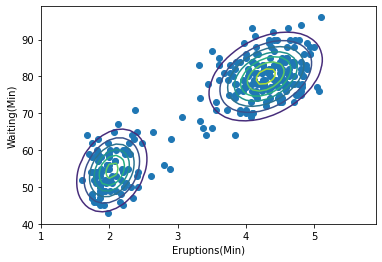

In [12]:
# visualize
def plot_contour(w, mus, covs):
    x = np.arange(1, 6, 0.1)
    y = np.arange(40, 100, 1)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            x = np.array([X[i, j], Y[i, j]])

            for k in range(len(mus)):
                mu, cov = mus[k], covs[k]
                Z[i, j] += w[k] * multivariate_normal(x, mu, cov)
    plt.contour(X, Y, Z)

plt.scatter(xs[:,0], xs[:,1])
plot_contour(phis, mus, covs)
plt.xlabel('Eruptions(Min)')
plt.ylabel('Waiting(Min)')
plt.show()

線は推測したパラメータで生成したものである。一応あっているように見える。

### 5.5.3 データ生成

次に、作成したモデルを使用してデータを生成する。

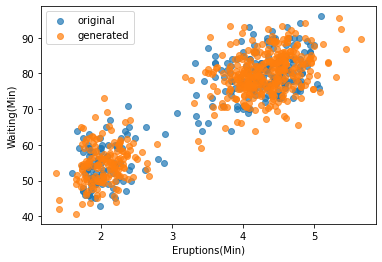

In [13]:
# genearte data
N = 500
new_xs = np.zeros((N, 2))
for n in range(N):
    k = np.random.choice(2, p=phis)
    mu, cov = mus[k], covs[k]
    new_xs[n] = np.random.multivariate_normal(mu, cov)

# visualize
plt.scatter(xs[:,0], xs[:,1], alpha=0.7, label='original')
plt.scatter(new_xs[:,0], new_xs[:,1], alpha=0.7, label='generated')
plt.legend()
plt.xlabel('Eruptions(Min)')
plt.ylabel('Waiting(Min)')
plt.show()